In [1]:
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights
import torchvision.transforms.functional as F
from torchvision import transforms
from torchvision.utils import flow_to_image
import numpy as np
import torch
import matplotlib.pyplot as plt
import gym
import cv2 as cv

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
model = raft_large(weights=Raft_Large_Weights.DEFAULT, progress=True).to(device)

In [4]:
model = model.eval()

In [5]:
weights = Raft_Large_Weights.DEFAULT

In [6]:
transforms_imgs = transforms.ToPILImage()
transforms_w = weights.transforms()

In [7]:
def preprocess(img1, img2):
    img1 = F.resize(transforms_imgs(img1), size=[208,160])
    img2 = F.resize(transforms_imgs(img2), size=[208,160])
    return transforms_w(img1, img2)

In [8]:
env = gym.make("MsPacmanNoFrameskip-v4")
start = env.reset()

In [9]:
env.unwrapped.get_action_meanings()

['NOOP',
 'UP',
 'RIGHT',
 'LEFT',
 'DOWN',
 'UPRIGHT',
 'UPLEFT',
 'DOWNRIGHT',
 'DOWNLEFT']

In [10]:
for _ in range(30):
    env.step(0)

In [12]:
step = env.step(3)

In [23]:
for _ in range(150):
    env.step(2)

In [13]:
for _ in range(15):
    env.step(1)

In [24]:
step2 = env.step(2)

In [25]:
img1, img2 = preprocess(step[0], step2[0])

In [26]:
list_of_flows = model(torch.stack([img1]).to(device), torch.stack([img2]).to(device))

In [27]:
predicted_flows = list_of_flows[-1]

In [28]:
flow_imgs = flow_to_image(predicted_flows)

In [29]:
flow_imgs[0].shape

torch.Size([3, 208, 160])

In [30]:
first_frame = np.array(step[0])#.astype('uint8')
prev_gray = cv.cvtColor(first_frame, cv.COLOR_RGB2GRAY)

mask = np.zeros_like(first_frame)
mask[..., 1] = 255

frame = np.array(step2[0])#.astype('uint8')
gray = cv.cvtColor(frame, cv.COLOR_RGB2GRAY)

flow = cv.calcOpticalFlowFarneback(prev_gray, gray,
                                flow = None, 
                                pyr_scale = 0.5, 
                                levels = 5, 
                                winsize= 5, 
                                iterations = 5, 
                                poly_n = 7, 
                                poly_sigma = 1.5, 
                                flags = 0)

magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])

mask[..., 0] = angle * 180 / np.pi / 2
mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)

flow = cv.cvtColor(mask, cv.COLOR_HSV2RGB)

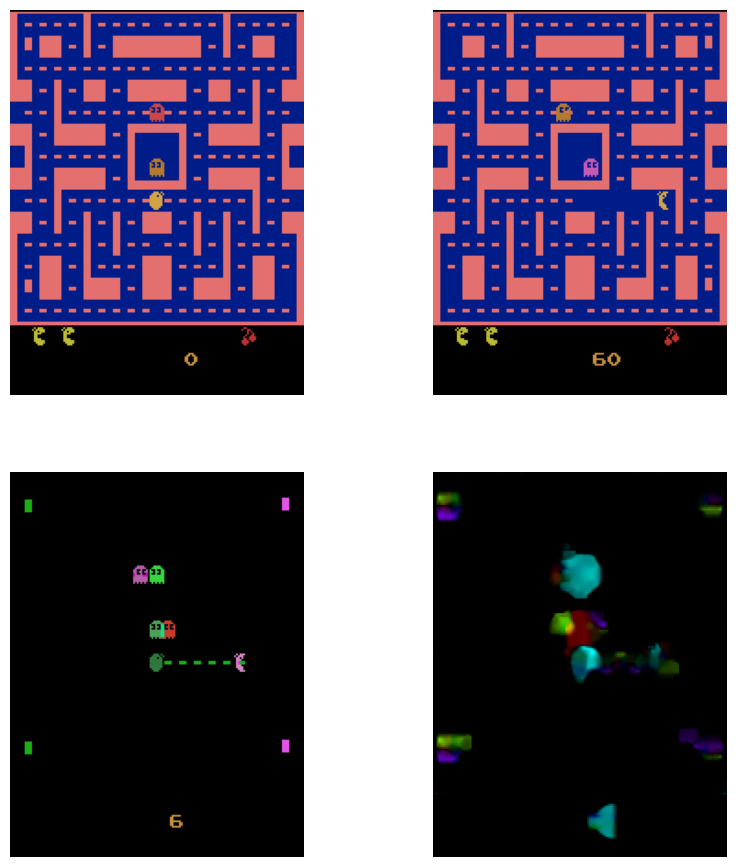

In [31]:
fig, axs = plt.subplots(2,2, figsize=(10,11))

axs[0,0].imshow(step[0])
axs[0,0].axis('off')
axs[0,1].imshow(step2[0])
axs[0,1].axis('off')
axs[1,0].imshow(step2[0]-step[0])
axs[1,0].axis('off')
axs[1,1].imshow(flow)
axs[1,1].axis('off')
plt.show()


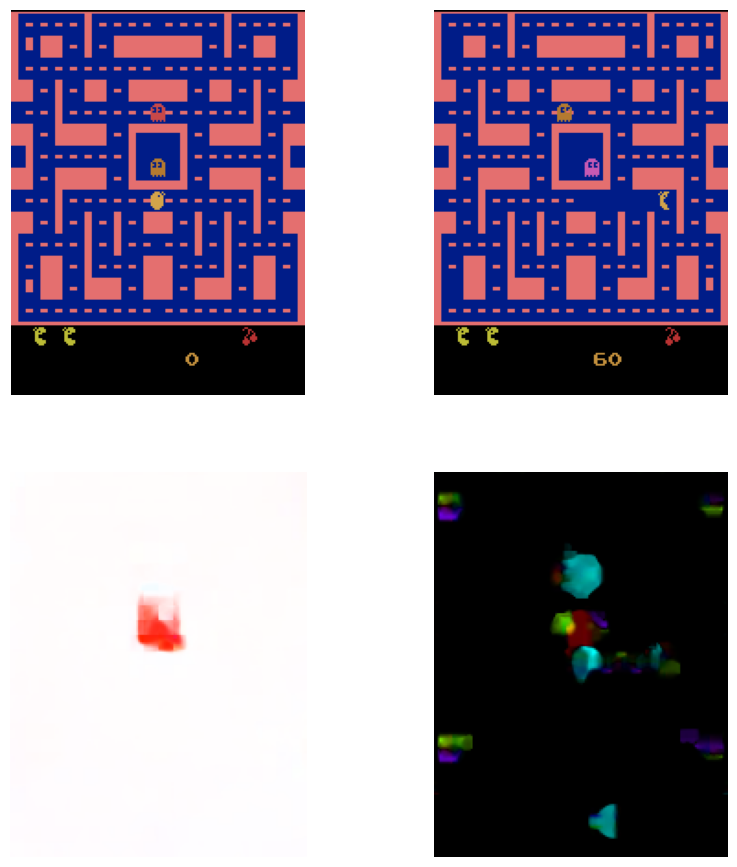

In [32]:
fig, axs = plt.subplots(2,2, figsize=(10,11))

axs[0,0].imshow(step[0])
axs[0,0].axis('off')
axs[0,1].imshow(step2[0])
axs[0,1].axis('off')
axs[1,0].imshow(flow_imgs[0].permute(1,2,0).to('cpu'))
axs[1,0].axis('off')
axs[1,1].imshow(step2[0]-step[0])
axs[1,1].axis('off')
plt.show()
